# Первое практическое задание по Байсовским методам в машинном обучении

Первый блок ноутбука: весь код.
Далее идет тестирование всех функций, нарисованы все необходимые графики и подсчитаны все перечисленные в задании распределения.

In [87]:
import numpy as np
from scipy.stats import binom as binom_st
import math
import time
from scipy.special import binom
from scipy.stats import binom as binom_st
from itertools import combinations_with_replacement as combinations
from fractions import Fraction
from operator import mul
from pylab import *
%matplotlib inline

params = dict(zip(['amin', 'amax', 'bmin', 'bmax', 'p1', 'p2', 'p3'], [75, 90, 500, 600, 0.1, 0.01, 0.3]))


def expect_value(var, params, model):
    if var == 'a':
        return 1.0 * (params['amin'] + params['amax']) / 2
    elif var == 'b':
        return 1.0 * (params['bmin'] + params['bmax']) / 2
    elif var == 'c':
        a = range(params['amin'], params['amax'] + 1)
        b = range(params['bmin'], params['bmax'] + 1)
        a_b = np.array([np.multiply(a, 0.1) + b_i for b_i in np.multiply(b, 0.01)])
        return sum(np.ravel(a_b)) / ((params['amax'] - params['amin'] + 1) * (params['bmax'] - params['bmin'] + 1))      
    elif var == 'd':
        return expect_value('c', params, model) * (1 + params['p3'])
    else:
        return 'Error'


def generate(N, a, b, params, model):
    if model == 4:
        c = np.random.poisson(a * params['p1'] + b * params['p2'], N)
        d = [c_i + binom_st.rvs(c_i, params['p3']) for c_i in c]
    elif model == 3:
        c = np.random.binomial(a, params['p1'], N) + np.random.binomial(b, params['p2'], N)
        d = [c_i + binom_st.rvs(c_i, params['p3']) for c_i in c]
    return d

#counting expectation
def count_expected_value(p, x):
    return sum(x * p)   

#counting variance
def count_variance(p, x):
    exp = count_expected_value(p, x)
    exp_2 = count_expected_value(p, x * x)
    return exp_2 - exp ** 2 

#counting binomial coefficients
def count_C(params):
    n = params['amax'] + params['bmax'] + 1
    c_matrix = np.ones((n, n))
    for j in range(1, n):
        for i in range(j + 1, n):
            c_matrix[i][j] = c_matrix[i - 1][j - 1] + c_matrix[i - 1][j]
    return c_matrix

#counting lambda pows
def get_pows(p, params):
    n = params['amax'] + params['bmax']
    p_pow = np.ones(2 * n + 1)
    for i in range(2 * n):
        p_pow[i + 1] = p_pow[i] * p
    return p_pow

#counting p(c_n|a,b)
def p_pois(a, b, params, model):
    n = params['amax'] + params['bmax'] + 1
    if model == 4:
        lambda_ = a * params['p1'] + b * params['p2']
        c = np.ones(n)
        c[0] = math.exp(-lambda_)
        for c_i in range(n - 1):
            c[c_i + 1] = c[c_i] * lambda_ / (c_i + 1)
        return c
    if model == 3:
        first_bin = binom_st.pmf(range(a+1), a, params['p1'])
        second_bin = binom_st.pmf(range(b+1), b, params['p2'])
        p = np.convolve(first_bin, second_bin)
        return np.append(p, np.zeros(n - len(p)))
    
def pa(params):
    a = np.array(range(params['amin'], params['amax'] + 1))
    n = params['amax'] - params['amin'] + 1
    p = np.array([1.0 / n] * n)
    return p, a

def pb(params):
    b = np.array(range(params['bmin'], params['bmax'] + 1))
    n = params['bmax'] - params['bmin'] + 1
    p = np.array([1.0 / n] * n)
    return p, b

def pc(d, params, model):
    N = len(d)
    c_max = params['amax'] + params['bmax']
    c_all = np.array(range(c_max + 1))
    p_a_p_b = 1.0 * (params['amax'] - params['amin'] + 1) * (params['bmax'] - params['bmin'] + 1)
    c_ab = np.array([p_pois(a, b, params, model) for a in range(params['amin'], params['amax']+1) for b in range(params['bmin'], params['bmax']+1)])
    for i, line in enumerate(c_ab):
        c_ab[i] *= pow(sum(line), N-1)
    p = []
    for column in c_ab.T:
        p.append(sum(column) / p_a_p_b)
    return np.array(p), c_all

def pd(d, params, model):
    N = len(d)
    c_max = params['amax'] + params['bmax']
    d_max = 2 * c_max
    d_all = np.array(range(d_max + 1))
    p_a_p_b = 1.0 * (params['amax'] - params['amin'] + 1) * (params['bmax'] - params['bmin'] + 1)
    
    matrix_c = count_C(params)
    p3_pow = get_pows(params['p3'], params)
    p3_inv_pow = get_pows(1 - params['p3'], params)
    
    c_ab = np.array([p_pois(a, b, params, model) for a in range(params['amin'], params['amax']+1) for b in range(params['bmin'], params['bmax']+1)])
    d_c =  np.array([p_d_c(c_item, d_item, matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1) for d_item in range(2*c_max+1)]).reshape(691, 1381)
    row_answer = np.dot(c_ab, d_c)
    
    for i, line in enumerate(row_answer):
        d_unknown = pow(sum(line), N-1)
        row_answer[i] *= d_unknown
    p = []
    for column in row_answer.T:
        p.append(sum(column) / p_a_p_b)
    return np.array(p), d_all


#counting matrix p(d_n|c_n)
def p_d_c(c, d, matrix_c, p3_pow, p3_inv_pow):
    if (c <= d <= 2*c):
        return matrix_c[c, d - c] * p3_pow[d - c] * p3_inv_pow[2*c - d]
    else:
        return 0

#counting distribution p(b|d_1..d_n)
#d can from 0 to N
#if len(d)==0, then counting p(b)
def pb_d(d, params, model):
    N = len(d)
    if N == 0:
        return pb(params)
    b_all = np.array(range(params['bmin'], params['bmax'] + 1))
    c_max = params['amax'] + params['bmax']
    
    matrix_c = count_C(params)
    p3_pow = get_pows(params['p3'], params)
    p3_inv_pow = get_pows(1 - params['p3'], params)
    c_ab = np.array([p_pois(a, b, params, model) for a in range(params['amin'], params['amax']+1) for b in range(params['bmin'], params['bmax']+1)])
    
    #if len(d) != N:
    #    d_c =  np.array([p_d_c(c_item, d_item, matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1) for d_item in range(2*c_max+1)]).reshape(691, 1381)
    #    if len(d) != 0:
    #        d_arr = []
    #        for step in range(len(d)):
    #            d_arr.append(np.array([p_d_c(c_item, d[step], matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1)])) 
    #        d_c = np.concatenate((d_c, np.column_stack(d_arr)), axis=1)

    d_arr = []
    for step in range(len(d)):
        d_arr.append(np.array([p_d_c(c_item, d[step], matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1)]))
    d_c = np.column_stack(d_arr)
           
    row_answer = np.dot(c_ab, d_c)
    answer = []
    for line in row_answer:
        partitioner = row_answer.shape[1]-len(d)     
        #if len(d) != N:
        #    d_unknown = pow(sum(line[:partitioner]), N-len(d))
        #    answer.append(np.prod(line[partitioner:]) * d_unknown)
        #else:
        answer.append(np.prod(line[partitioner:]))
    
    p_a_p_b = 1.0 * (params['amax'] - params['amin'] + 1) * (params['bmax'] - params['bmin'] + 1)
    p = np.array([(sum(answer[i::101]) / p_a_p_b) for i in range(101)])
    return p / sum(p), b_all

#counting distribution p(b|a,d_1..d_n)
#d can be from 0 to N
#if len(d)==0, then count p(b|a)=p(b)
def pb_ad(a, d, params, model):
    N = len(d)
    if N == 0:
        return pb(params)
    b_all = np.array(range(params['bmin'], params['bmax'] + 1))
    c_max = params['amax'] + params['bmax']
    
    matrix_c = count_C(params)
    p3_pow = get_pows(params['p3'], params)
    p3_inv_pow = get_pows(1 - params['p3'], params)
    c_ab = np.array([p_pois(a, b, params, model) for b in range(params['bmin'], params['bmax']+1)])
    
    #if len(d) != N:
    #    d_c =  np.array([p_d_c(c_item, d_item, matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1) for d_item in range(2*c_max+1)]).reshape(691, 1381)
    #    if len(d) != 0:
    #        d_arr = []
    #        for step in range(len(d)):
    #            d_arr.append(np.array([p_d_c(c_item, d[step], matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1)])) 
    #        d_c = np.concatenate((d_c, np.column_stack(d_arr)), axis=1)

    d_arr = []
    for step in range(len(d)):
        d_arr.append(np.array([p_d_c(c_item, d[step], matrix_c, p3_pow, p3_inv_pow) for c_item in range(c_max+1)]))
    d_c = np.column_stack(d_arr)
           
    row_answer = np.dot(c_ab, d_c)
    p = []
    p_a_p_b = 1.0 * (params['amax'] - params['amin'] + 1) * (params['bmax'] - params['bmin'] + 1)
    for line in row_answer:
        partitioner = row_answer.shape[1]-len(d)     
        #if len(d) != N:
        #    d_unknown = pow(sum(line[:partitioner]), N-len(d))
        #    p.append(np.prod(line[partitioner:]) * d_unknown / p_a_p_b)
        #else:
        p.append(np.prod(line[partitioner:]) / p_a_p_b)

    return np.array(p) / sum(p), b_all


#plotting one distribution and saving picture,
#each plot has label (a means the existence of variable a in conditional distribution)
def plot_p(b, p, n_last, a=False):
    figure(figsize=(7,4))
    rcParams.update({'font.size': 18})
    subplots_adjust(hspace=.7)
    if a:
        if n_last == 0:
            label = 'p(b|a)'
        elif n_last == 1:
            label = 'p(b|a,d_1)'
        else:
            label = 'p(b|a,d_1..d_'+str(n_last)+')'
    else:
        if n_last == 0:
            label = 'p(b)'
        elif n_last == 1:
            label = 'p(b|d_1)'
        else:
            label = 'p(b|d_1..d_'+str(n_last)+')'
    xlabel('b')
    ylabel(label)
    title(label)
    ylim([0,0.025])
    grid(True)
    plot(b, p)
    savefig('{0}.png'.format(n_last))


#plotting several distributions on the same picture
def plot_many(p, b, step, a=False):
    N = len(p)
    colours = ['b'] * (N - 1)
    colours.append('black')
    alpha_step = 1.0 / N
    cur_alpha = alpha_step
    alphas = []
    labels = []
    for i in range(N):
        alphas.append(cur_alpha)
        cur_alpha += alpha_step
        labels.append('n={0}'.format(step*i))
    plt.figure(figsize = (16, 6))
    for i in range(N):
        plot(b, p[i], label=labels[N-i-1], color = colours[i], alpha=alphas[i])

    rcParams.update({'font.size': 18})
    subplots_adjust(hspace=.7)
    if a:
        label = 'p(b|a,d_1,..,d_n)'
    else:
        label = 'p(b|d_1,..,d_n)'
    
    ylabel(label)
    title(label)
    ylim([0,0.025])
    grid(True)
    legend(loc="upper right")

#plotting expectation and variance for p(b|a,d_1,..,d_n) or p(b|d_1,..,d_n)
def plot_exp_var(exp, var, is_a, N):
    figure(figsize=(7,4))
    rcParams.update({'font.size': 18})
    subplots_adjust(hspace=.7)
    xlabel('n')
    ylabel('Exp.values')
    if is_a:
        title('Exp.values for p(b|a,d_1,..,d_n)')
    else:
        title('Exp.values for p(b|d_1,..,d_n)')
    ylim([500,600])
    grid(True)
    plot(range(N+1), exp[::-1])

    figure(figsize=(7,4))
    rcParams.update({'font.size': 18})
    subplots_adjust(hspace=.7)
    xlabel('n')
    ylabel('Variance')
    if is_a:
        title('Variances for p(b|a,d_1,..,d_n)')
    else:
        title('Variances for p(b|d_1,..,d_n)')
    ylim([500,1000])
    grid(True)
    plot(range(N+1), var[::-1])

#data preparation for plotting and counting expectation and variance
#plots the distributions, also expectation and variance pictures
#model - 3 or 4
#exp_type - the type of the experiment(1 or 2, influence generating d)
#is_a - whether a is known
#step - how many plots should be on one picture
def process(model, exp_type, is_a, N, step):
    if exp_type == 1:
        a = int(expect_value('a', params, model))
        b = int(expect_value('b', params, model))
        d = generate(N, a, b, params, model)
    if exp_type == 2:
        d = [expect_value('d', params, model)] * N
        a = int(expect_value('a', params, model))

    exp = []
    var = []
    p_arr = []
    if is_a:
        p, b = pb_ad(a, d, params, model)
    else:
        p, b = pb_d(d, params, model)
    exp.append(round(count_expected_value(p, b), 2))
    var.append(round(count_variance(p, b), 2))
    p_arr.append(p)
    #print 'Expected value for {0}: {1}'.format(len(d), round(count_expected_value(p, b), 2))
    #print 'Variance for {0}: {1}'.format(len(d), round(count_variance(p, b), 2))
    #plot_p(b, p, N, True)

    for margin in range(N):
        if is_a:
            p, b = pb_ad(a, d[:-(margin+1)], params, model)
        else:
            p, b = pb_d(d[:-(margin+1)], params, model)
        exp.append(round(count_expected_value(p, b), 2))
        var.append(round(count_variance(p, b), 2))
        
        if (margin + 1) % step == 0:
            p_arr.append(p)          
            #print 'Expected value for {0}: {1}'.format(len(d[:-(margin+1)]), round(count_expected_value(p, b), 2))
            #print 'Variance for {0}: {1}'.format(len(d[:-(margin+1)]), round(count_variance(p, b), 2))    
            #plot_p(b,p,N-margin-1, True)
    
    plot_exp_var(exp, var, is_a, N)
    plot_many(p_arr, b, step, is_a)

#1st part of the task
def process_exp_var(params, model, N):
    a = int(expect_value('a', params, model))
    b = int(expect_value('b', params, model))
    d = generate(N, a, b, params, model)
    print 'Counting expectations and variances of prior distributions:'
    p, a = pa(params)
    print 'a. expectation:', count_expected_value(p, a), 'variance:', count_variance(p, a)

    p, b = pb(params)
    print 'b:', count_expected_value(p, b), 'variance:',  count_variance(p, b)

    p, c = pc(d, params, model)
    print 'c:', count_expected_value(p, c), 'variance:',  count_variance(p, c)

    p, d = pd(d, params, model)
    print 'd:', count_expected_value(p, d), 'variance:', count_variance(p, d)

#4th part of the task
def timer(params, model, N):
    a = int(expect_value('a', params, model))
    b = int(expect_value('b', params, model))
    d = generate(N, a, b, params, model)
    
    t = time.clock()
    pc(d, params, model)
    print "pc (N = {0}): {1:.5f}".format(N, time.clock() - t)
    
    t = time.clock()
    pd(d, params, model)
    print "pd (N = {0}): {1:.5f}".format(N, time.clock() - t)   
    
    t = time.clock()
    pb_ad(a, d[:10], params, model)
    print "pb_ad (N = {0}): {1:.5f}".format(10, time.clock() - t)
    
    t = time.clock()
    pb_ad(a, d[:30], params, model)
    print "pb_ad (N = {0}): {1:.5f}".format(30, time.clock() - t)
    
    t = time.clock()
    pb_ad(a, d, params, model)
    print "pb_ad (N = {0}): {1:.5f}".format(N, time.clock() - t)
    
    t = time.clock()
    pb_d(d[:10], params, model)
    print "pb_d (N = {0}): {1:.5f}".format(10, time.clock() - t)
    
    t = time.clock()
    pb_d(d[:30], params, model)
    print "pb_d (N = {0}): {1:.5f}".format(30, time.clock() - t)
    
    t = time.clock()
    pb_d(d, params, model)
    print "pb_d (N = {0}): {1:.5f}".format(N, time.clock() - t)


#### Первый пункт

In [83]:
params = dict(zip(['amin', 'amax', 'bmin', 'bmax', 'p1', 'p2', 'p3'], [75, 90, 500, 600, 0.1, 0.01, 0.3]))

In [84]:
model = 4
N = 50
process_exp_var(params, model, N)

Counting expectations and variances of prior distributions:
a. expectation: 82.5 variance: 21.25
b: 550.0 variance: 850.0
c: 13.75 variance: 14.0475
d: 17.875 variance: 26.627775


#### Второй пункт

Протестируем генератор выборки $d_1$, .. , $d_N$ при $N=50$:

In [43]:
a = (params['amax'] + params['amin']) / 2
b = (params['bmax'] + params['bmin']) / 2
print generate(N, a, b, params, 4)

[15, 17, 23, 19, 10, 18, 30, 24, 23, 18, 21, 23, 12, 11, 17, 11, 23, 15, 14, 19, 16, 15, 13, 16, 21, 8, 15, 19, 22, 19, 17, 16, 21, 14, 27, 19, 13, 22, 11, 25, 23, 22, 31, 25, 16, 17, 18, 19, 14, 23]


#### Третий пункт

Пронаблюдаем, как происходит уточнение прогноза для $b$ по мере прихода новой косвенной информации. Строим графики и ищем матожидание и дисперсию для распределений $p(b), p(b|d_1), .., p(b|d_1, .. , d_N)$ для выборки:
1) сгенерированной из модели при параметрах $a$, $b$, равных матожиданиям своих априорных распределений, округленных до ближайшего целого
2) $d_1 = .. = d_N$, где $d_n$ - матожидание своего априорного распределения, округленного до ближайшего целого.

Функция process выполняет все необходимые для эксперимента подсчеты и рисует графики распределений и графики изменения мат.ожидания и дисперсии распределения $p(b|d_1,..,d_n)$ или $p(b|a, d_1,..,d_n)$ в зависимости от $n$.

Подсчет для первого эксперимента ($a$ неизвестно):

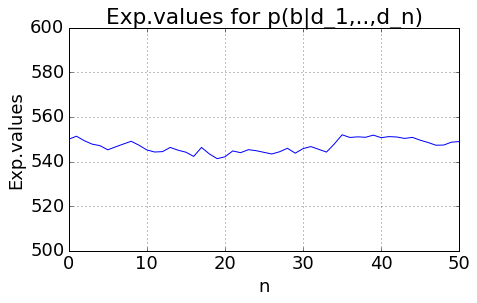

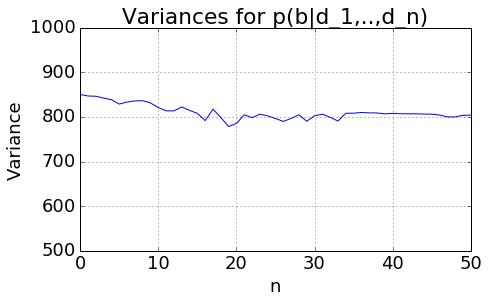

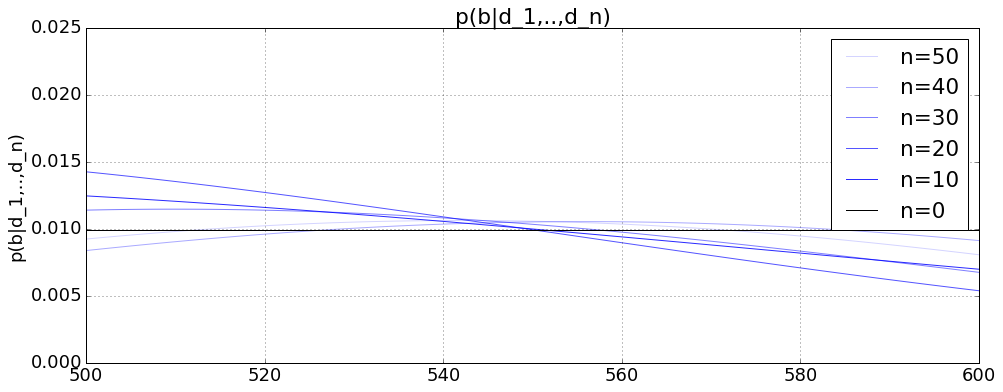

In [44]:
model = 4
exp_type = 1
is_a = False
N = 50
step = 10
process(model, exp_type, is_a, N, step)

Эксперимент по схеме 2, если $a$ неизвестно:

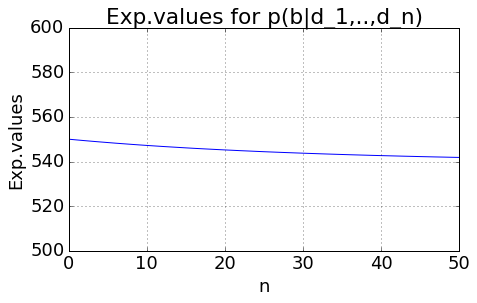

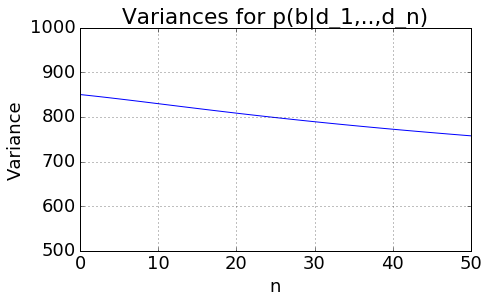

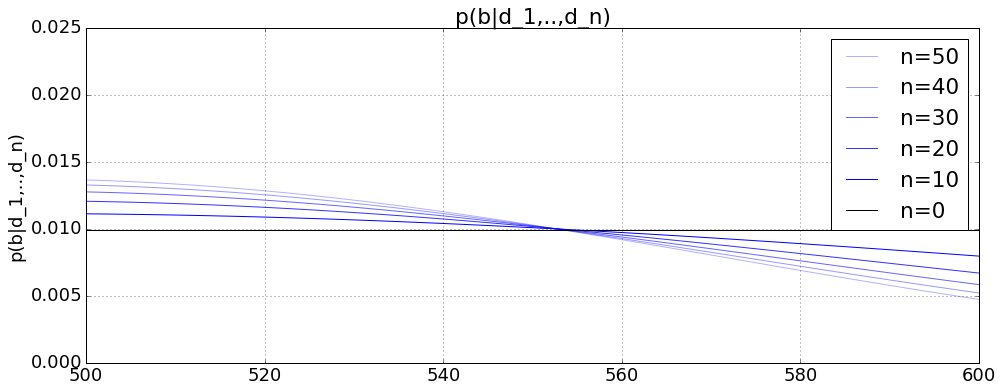

In [36]:
model = 4
exp_type = 2
is_a = False
N = 50
step = 10
process(model, exp_type, is_a, N, step)

Проводим дополнительные эксперименты, если дополнительно известно значение $a$:

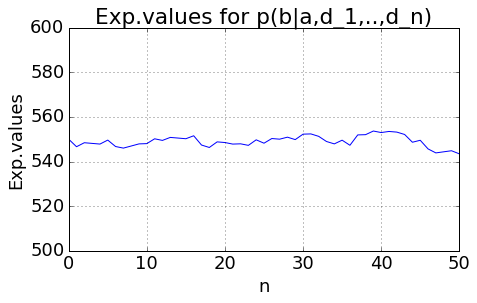

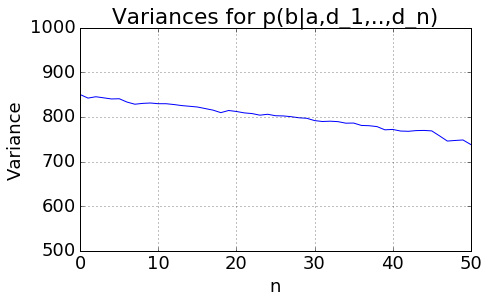

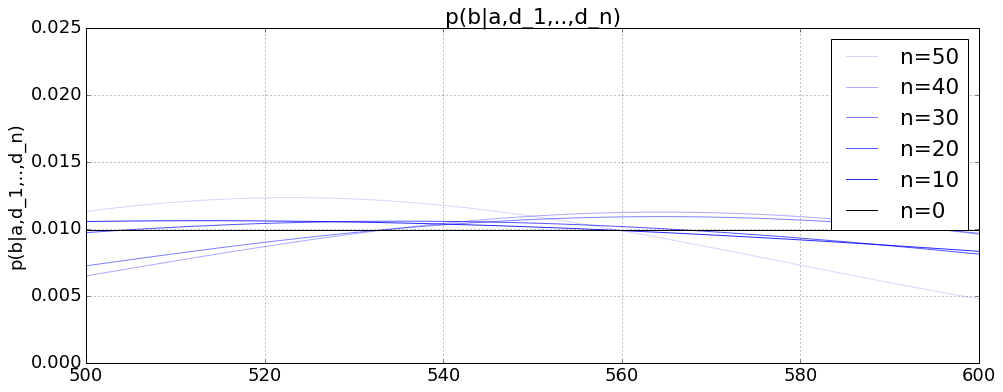

In [85]:
model = 4
exp_type = 1
is_a = True
N = 50
step = 10
process(model, exp_type, is_a, N, step)

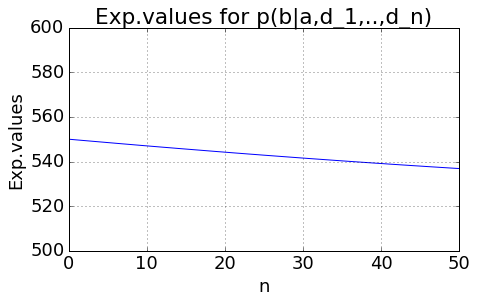

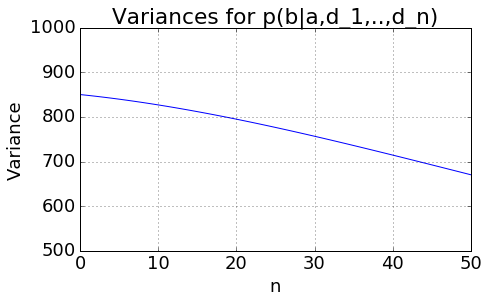

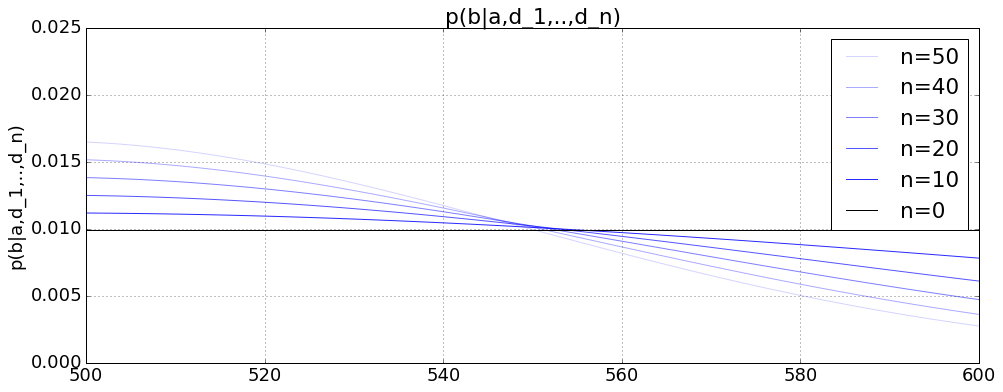

In [86]:
model = 4
exp_type = 2
is_a = True
N = 50
step = 10
process(model, exp_type, is_a, N, step)

#### Четвертый пункт

Оценки по времени:

In [88]:
model = 4
N = 50
timer(params, model, N)

pc (N = 50): 0.96265
pd (N = 50): 1.99899
pb_ad (N = 10): 0.39245
pb_ad (N = 30): 0.36657
pb_ad (N = 50): 0.40509
pb_d (N = 10): 1.25733
pb_d (N = 30): 1.26695
pb_d (N = 50): 1.24190


#### Пятый пункт

Проводим все предыдущие эксперименты для точной модели 3:

In [76]:
model = 3
process_exp_var(params, model, N)

Counting expectations and variances of prior distributions:
a. expectation: 82.5 variance: 21.25
b: 550.0 variance: 850.0
c: 13.75 variance: 13.1675000001
d: 17.875 variance: 25.1405750001


In [77]:
a = (params['amax'] + params['amin']) / 2
b = (params['bmax'] + params['bmin']) / 2
print generate(N, a, b, params, 3)

[27, 11, 16, 22, 21, 12, 8, 20, 22, 18, 18, 20, 16, 21, 24, 19, 17, 12, 18, 20, 13, 16, 9, 15, 14, 23, 24, 17, 14, 14, 21, 14, 20, 23, 30, 18, 15, 17, 18, 22, 18, 15, 19, 10, 14, 21, 16, 10, 12, 15]


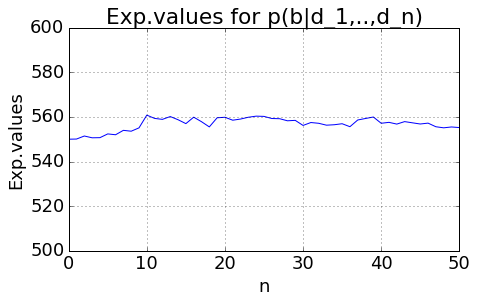

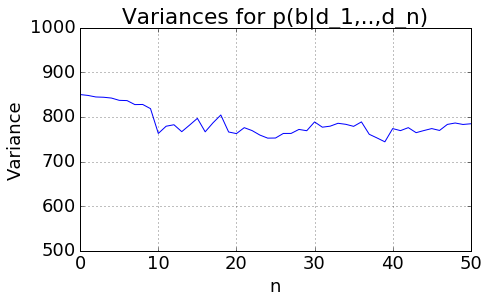

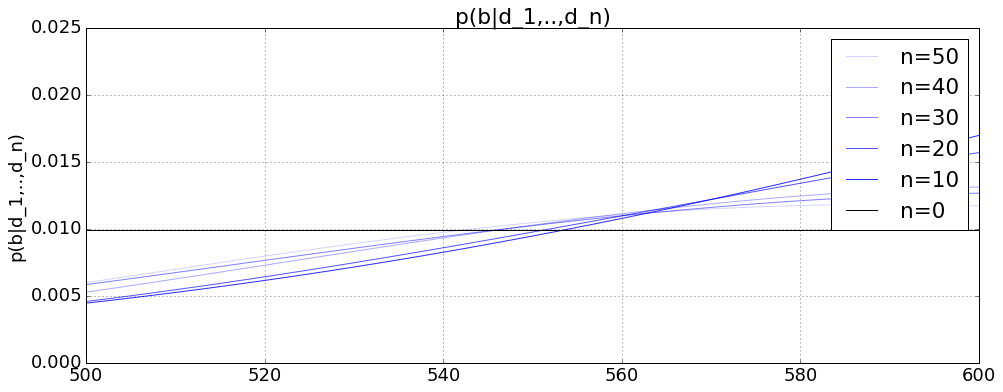

In [78]:
exp_type = 1
is_a = False
step = 10
process(model, exp_type, is_a, N, step)

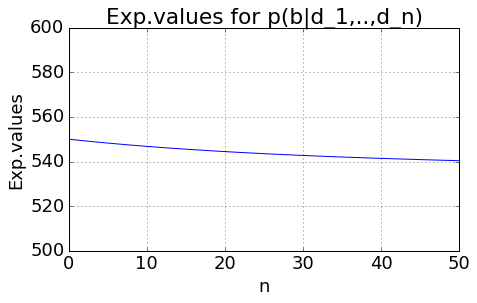

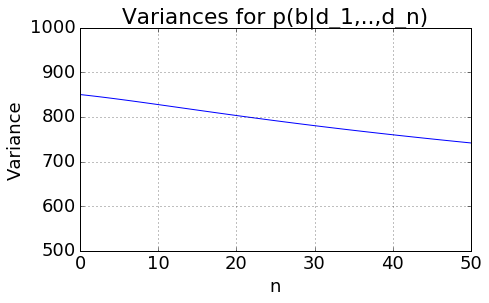

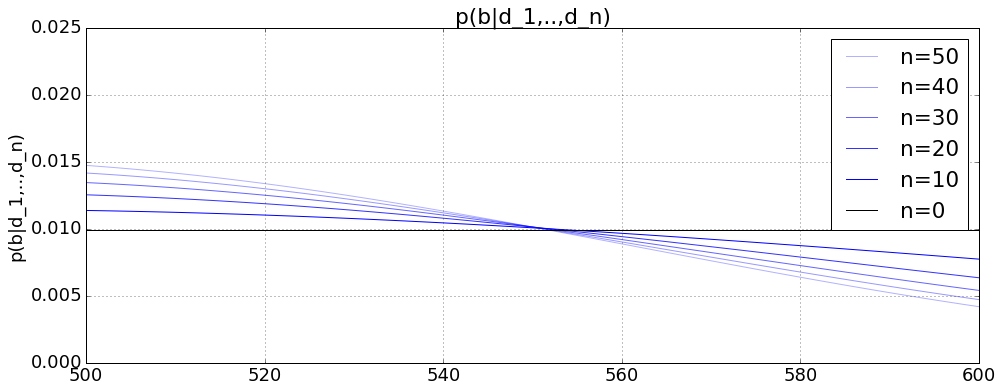

In [45]:
exp_type = 2
is_a = False
step = 10
process(model, exp_type, is_a, N, step)

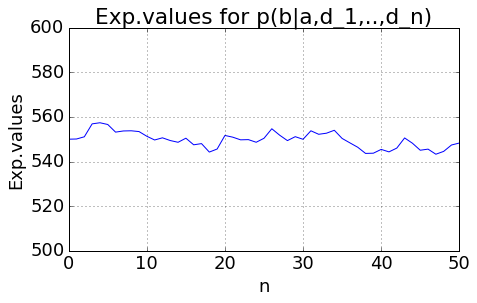

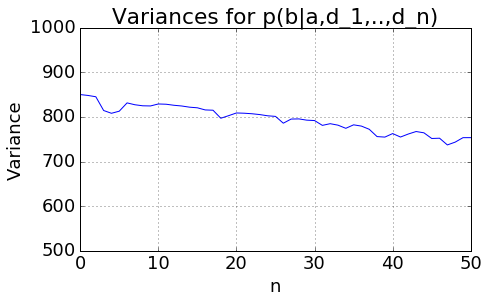

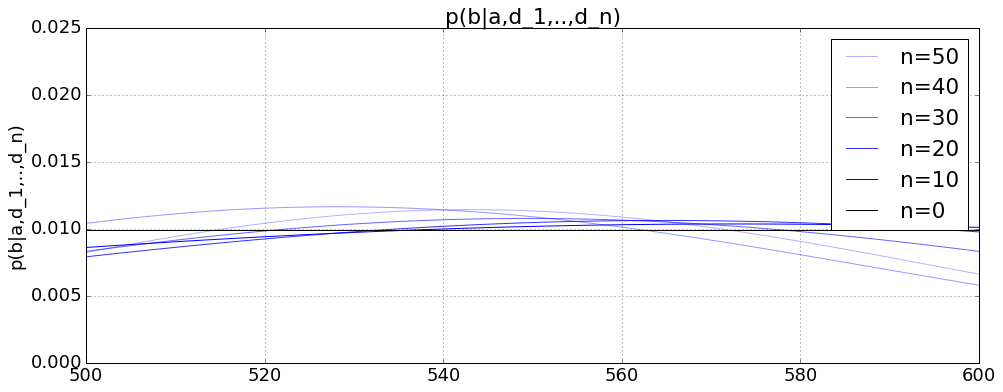

In [46]:
exp_type = 1
is_a = True
step = 10
process(model, exp_type, is_a, N, step)

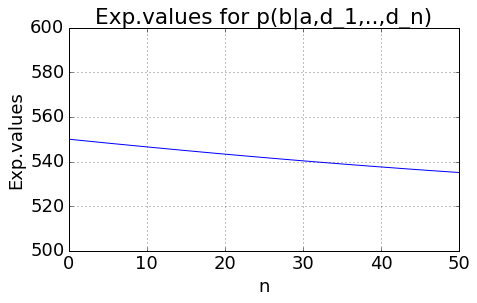

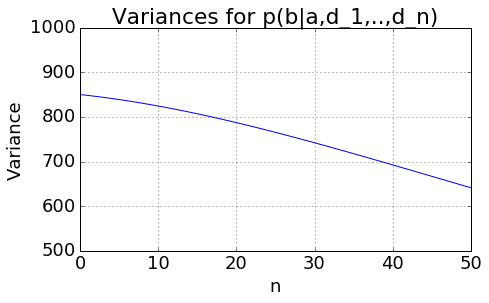

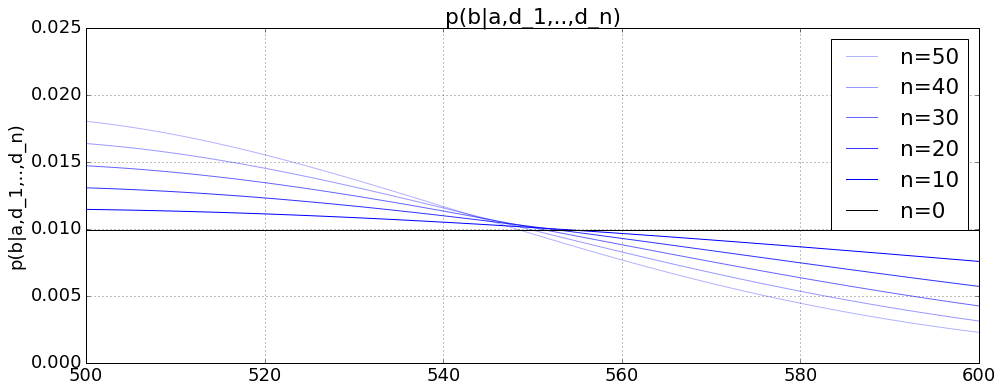

In [47]:
exp_type = 2
is_a = True
step = 10
process(model, exp_type, is_a, N, step)

In [81]:
model = 3
timer(params, model, N)

pc (N = 50): 1.06477
pd (N = 50): 2.15140
pb_ad (N = 10): 0.38078
pb_ad (N = 30): 0.37437
pb_ad (N = 50): 0.38919
pb_d (N = 10): 1.41865
pb_d (N = 30): 1.36347
pb_d (N = 50): 1.38028
